# Logistic Regression

In this example we will see how to classify images as horses or people using logistic regression. The tutorial builds upon the concepts introduced in the [Objax basics tutorial](Objax_Basics.html). Consider reading that tutorial first, or you can always go back.

## Imports

First, we import the modules we will use in our code.

In [1]:
%pip --quiet install objax

import matplotlib.pyplot as plt
import os

import numpy as np
import tensorflow_datasets as tfds

import objax
from objax.util import EasyDict

## Loading the Dataset

Next, we will load the "[horses_or_humans](https://www.tensorflow.org/datasets/catalog/horses_or_humans)" dataset from [TensorFlow DataSets](https://www.tensorflow.org/datasets/api_docs/python/tfds).

The ``prepare`` method downscales the image by 3x to reduce training time, flattens each image to a vector, and rescales each pixel value to [-1,1].

In [2]:
# Data: train has 1027 images - test has 256 images
# Each image is 300 x 300 x 3 bytes
DATA_DIR = os.path.join(os.environ['HOME'], 'TFDS')
data = tfds.as_numpy(tfds.load(name='horses_or_humans', batch_size=-1, data_dir=DATA_DIR))

def prepare(x, downscale=3):
  """Normalize images to [-1, 1] and downscale them to 100x100x3 (for faster training) and flatten them."""
  s = x.shape
  x = x.astype('f').reshape((s[0], s[1] // downscale, downscale, s[2] // downscale, downscale, s[3]))
  return x.mean((2, 4)).reshape((s[0], -1)) * (1 / 127.5) - 1

train = EasyDict(image=prepare(data['train']['image']), label=data['train']['label'])
test = EasyDict(image=prepare(data['test']['image']), label=data['test']['label'])
ndim = train.image.shape[-1]
del data

## Visualizing the Data

Let's see a couple of the images in the dataset and their corresponding labels. Note that label ``0`` corresponds to a horse, while label ``1`` corresponds to a human.

label for horse_image: 0


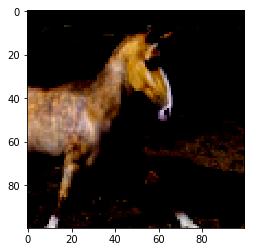

In [3]:
#sample image of a horse.
horse_image = np.reshape(train.image[0], [100,100,3])
plt.imshow(horse_image)
print("label for horse_image:", train.label[0])

label for human_image: 1


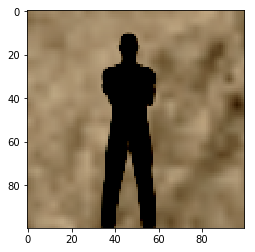

In [4]:
#sample image of a human.
human_image = np.reshape(train.image[9], [100, 100, 3])
plt.imshow(human_image)
print("label for human_image:", train.label[9])


## Model Definition

``objax.nn.Linear(ndim, 1)`` is a linear neural unit with ``ndim`` inputs and a single output. Given input $\mathbf{X}$, the output is equal to $\mathbf{W}\mathbf{X} + \mathbf{b}$ where $\mathbf{W}, \mathbf{b}$ are the model's parameters. These parameters are available through ``model.vars()``



In [5]:
# Settings
lr = 0.0001  # learning rate
batch = 256
epochs = 20

model = objax.nn.Linear(ndim, 1)
print(model.vars())

(Linear).b                  1 (1,)
(Linear).w              30000 (30000, 1)
+Total(2)               30001


## Model Inference

Now that we have defined the model we can use to classify images. To do so, we call the model with an image from the ``train`` dataset we previously prepared. Notice that we use the image of a human we previously visualized. 

We get the output of the model by calling ``model()``. We then apply the sigmoid activation function and round the output. Activation outputs lower than or equal to 0.5 are rounded to zero (i.e., horses) whereas outputs larger than 0.5 are rounded to one (i.e., humans). 



In [6]:
# This is an image of a human.
print(np.round(objax.functional.sigmoid(model(train.image[9]))))

[1.]


Considering that we initialized the model with random weights, it should not come as a surprise that the model may misclassy a human as a horse. 

## Optimizer and Loss Function

In this example we use the ``objax.optimizer.SGD`` optimizer. Next, we define the loss function we will use to optimize the network. In this case we use the cross entropy loss function. Note that we use `objax.functional.loss.sigmoid_cross_entropy_logits` because we perform binary classification.

In [7]:
opt = objax.optimizer.SGD(model.vars())

# Cross Entropy Loss
def loss(x, label):
  return objax.functional.loss.sigmoid_cross_entropy_logits(model(x)[:, 0], label).mean()

## Back Propagation and Gradient Descent

``objax.GradValues`` calculates the gradient of ``loss`` wrt ``model.vars()``. If you want to learn more about gradients read the [Understanding Gradients](../advanced/gradients.html#understanding-gradients) in-depth topic.

The ``train_op`` function implements the core of backward propagation and gradient descent. First, we calculate the gradient ``g`` and then pass it to the optimizer which updates the model’s weights.

In [8]:
gv = objax.GradValues(loss, model.vars())

def train_op(x, label):
  g, v = gv(x, label)  # returns gradients, loss
  opt(lr, g)
  return v

# This line is optional: it is compiling the code to make it faster.
train_op = objax.Jit(train_op, gv.vars() + opt.vars())

## Training and Evaluation Loop

For each of the training epochs we process all the training data, contained in the train dictionary, in batches of ``batch`` size. At the end of each epoch we compute the classification accuracy by comparing the model’s predictions over the test data to the ground truth labels.


In [9]:
for epoch in range(epochs):
  # Train
  avg_loss = 0
  # randomly shuffle training data
  shuffle_idx = np.random.permutation(train.image.shape[0])
  for it in range(0, train.image.shape[0], batch):
    sel = shuffle_idx[it: it + batch]
    avg_loss += float(train_op(train.image[sel], train.label[sel])[0]) * len(sel)
  avg_loss /= it + batch

  # Eval
  accuracy = 0
  for it in range(0, test.image.shape[0], batch):
    x, y = test.image[it: it + batch], test.label[it: it + batch]
    accuracy += (np.round(objax.functional.sigmoid(model(x)))[:, 0] == y).sum()
  accuracy /= test.image.shape[0]
  print('Epoch %04d  Loss %.2f  Accuracy %.2f' % (epoch + 1, avg_loss, 100 * accuracy))

Epoch 0001  Loss 0.25  Accuracy 82.81
Epoch 0002  Loss 0.25  Accuracy 82.81
Epoch 0003  Loss 0.25  Accuracy 83.59
Epoch 0004  Loss 0.25  Accuracy 82.81
Epoch 0005  Loss 0.25  Accuracy 82.03
Epoch 0006  Loss 0.25  Accuracy 80.86
Epoch 0007  Loss 0.25  Accuracy 80.86
Epoch 0008  Loss 0.24  Accuracy 80.86
Epoch 0009  Loss 0.24  Accuracy 82.03
Epoch 0010  Loss 0.24  Accuracy 83.20
Epoch 0011  Loss 0.24  Accuracy 82.03
Epoch 0012  Loss 0.24  Accuracy 80.86
Epoch 0013  Loss 0.24  Accuracy 81.25
Epoch 0014  Loss 0.24  Accuracy 83.59
Epoch 0015  Loss 0.24  Accuracy 84.38
Epoch 0016  Loss 0.24  Accuracy 85.16
Epoch 0017  Loss 0.24  Accuracy 84.77
Epoch 0018  Loss 0.24  Accuracy 83.98
Epoch 0019  Loss 0.24  Accuracy 83.20
Epoch 0020  Loss 0.24  Accuracy 83.59


## Model Inference After Training

Now that the network is trained we can retry classification example above:

In [10]:
print(np.round(objax.functional.sigmoid(model(train.image[9]))))

[1.]


## Next Steps

We saw how we can define, use, and train a very simple model in Objax to classify images of humans and horses. Next, we will learn how to [create custom models](Custom_Networks.html) to classify handwritten digits.